In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,normalize
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

%matplotlib inline
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


In [2]:
dforiginal=pd.read_csv("/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv")
df=dforiginal
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [4]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [5]:
df=df.drop(['CustomerID'], axis=1)
df

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
...,...,...,...,...
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18


In [6]:
df['Annual Income (k$)'].iplot(kind='hist',bins=20, yTitle="Count", xTitle="Annual Income", title="Annual Income Distribution",
                  theme="henanigans")

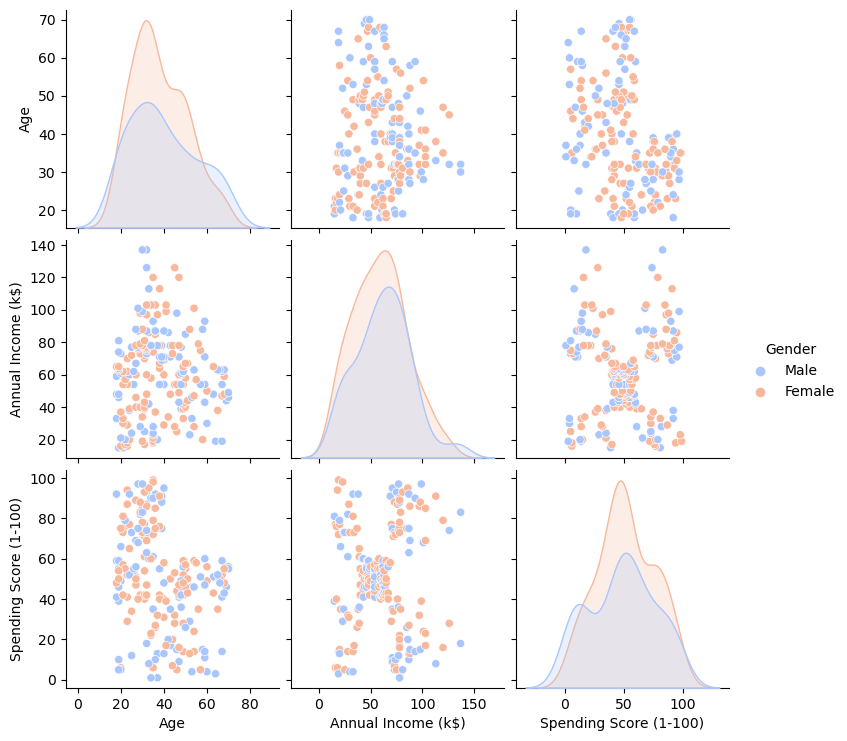

In [7]:
sns.pairplot(df,hue='Gender',palette='coolwarm')

<Axes: xlabel='Gender', ylabel='count'>

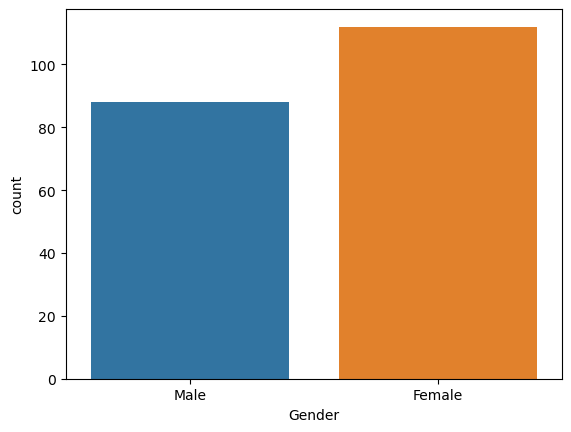

In [8]:
sns.countplot(x='Gender',data=df)

In [9]:
avg_gender_df = df.groupby(by=["Gender"]).mean()

avg_gender_df

,Age,Annual Income (k$),Spending Score (1-100)
Gender,,,
Female,38.098214,59.250000,51.526786
Male,39.806818,62.227273,48.511364


In [10]:
avg_gender_df.iplot(kind="bar",
                  subplots=True,
                  sortbars=True,
                  keys = ["Age", "Annual Income (k$)", "Spending Score (1-100)"],
                  yTitle="Average", xTitle="Gender", title="Averages separated by Gender",
                  theme="henanigans"
                  )

In [11]:
avg_gender_df.iplot(kind="bar",
                  sortbars=True,
                  yTitle="Averages", xTitle="By Gender", title="Averages by Gender",
                  theme="ggplot"
                  )

In [12]:
df.iplot(kind='box')

In [13]:
df['Gender'].replace(['Male', 'Female'],
                        [0, 1], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Gender                  200 non-null    int64
 1   Age                     200 non-null    int64
 2   Annual Income (k$)      200 non-null    int64
 3   Spending Score (1-100)  200 non-null    int64
dtypes: int64(4)
memory usage: 6.4 KB


<Axes: >

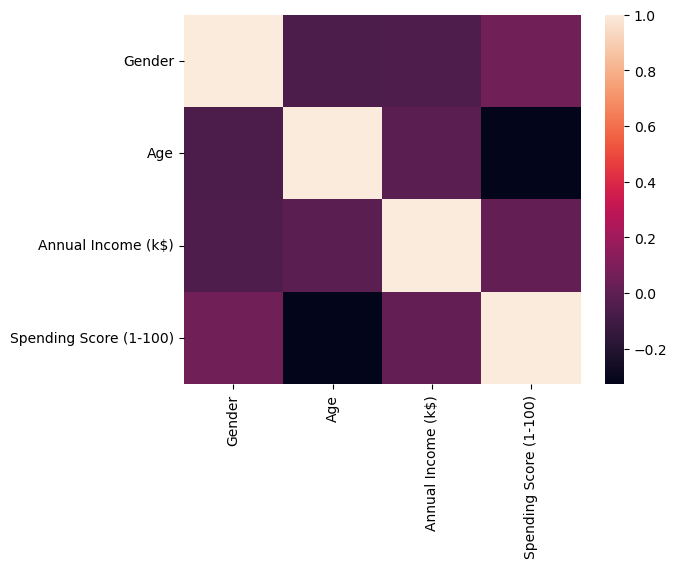

In [14]:
sns.heatmap(df.corr())

In [15]:
dfnormalized = pd.DataFrame(normalize(df,axis=0), columns=df.columns)
dfnormalized

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0.000000,0.032551,0.016074,0.048876
1,0.000000,0.035978,0.016074,0.101511
2,0.094491,0.034265,0.017146,0.007519
3,0.094491,0.039404,0.017146,0.096498
4,0.094491,0.053110,0.018218,0.050129
...,...,...,...,...
195,0.094491,0.059963,0.128596,0.099005
196,0.094491,0.077095,0.135026,0.035090
197,0.000000,0.054823,0.135026,0.092739
198,0.000000,0.054823,0.146814,0.022558


<Axes: xlabel='Spending Score (1-100)', ylabel='Count'>

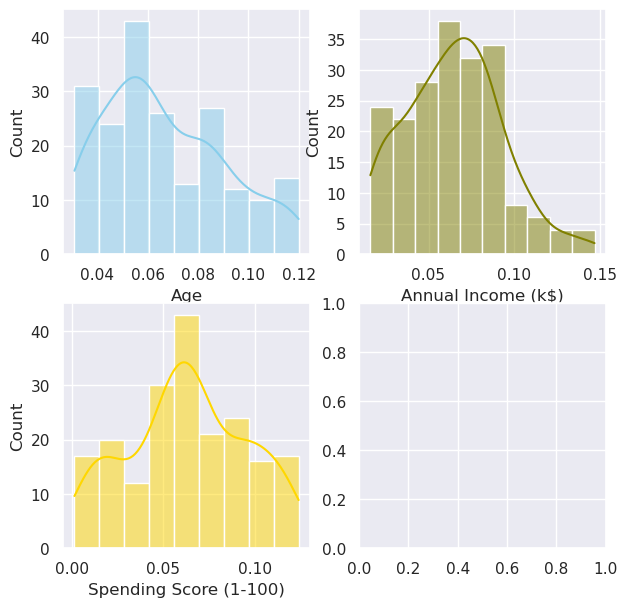

In [16]:
sns.set(style="darkgrid")
#df = sns.load_dataset("dfnormalized")

fig, axs = plt.subplots(2, 2, figsize=(7, 7))

sns.histplot(data=dfnormalized, x="Age", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=dfnormalized, x="Annual Income (k$)", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=dfnormalized, x="Spending Score (1-100)", kde=True, color="gold", ax=axs[1, 0])

In [17]:
# define transform
pca = PCA(n_components=3)
# prepare transform on dataset
pca.fit(dfnormalized)
# apply transform to dataset
dfnormalized = pca.transform(dfnormalized)
pca.explained_variance_ratio_

array([0.48152025, 0.2481376 , 0.17034398])

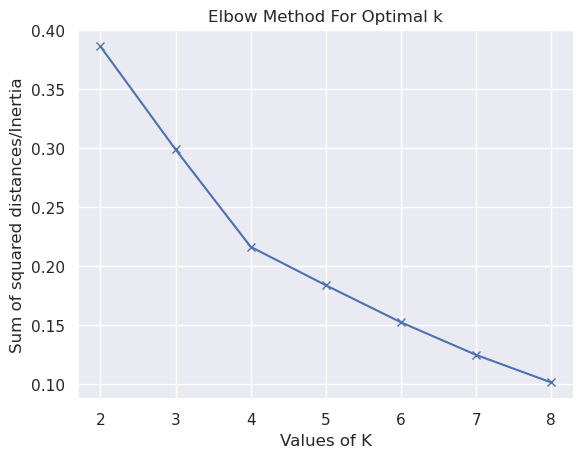

In [18]:
Sum_of_squared_distances = []
K = range(2,9)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(dfnormalized)
    Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K,Sum_of_squared_distances,'x-')
plt.xlabel('Values of K')
plt.ylabel('Sum of squared distances/Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

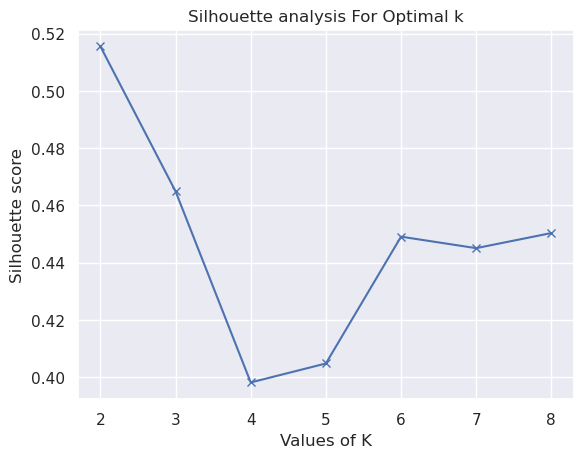

In [19]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(dfnormalized)
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg.append(silhouette_score(dfnormalized, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg,'x-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

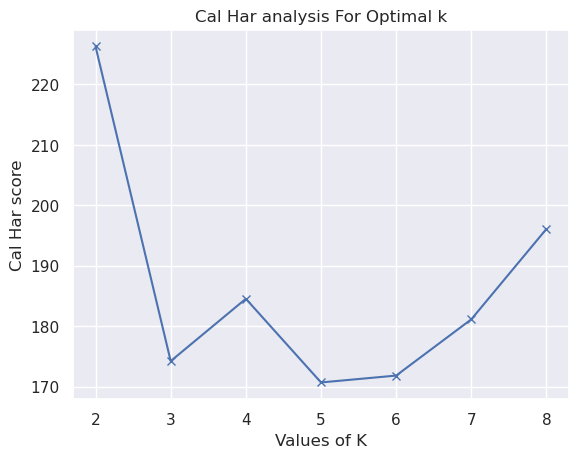

In [20]:
range_n_clusters = range(2,9)
calinski_harabasz_avg = []
for num_clusters in range_n_clusters:
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(dfnormalized)
    cluster_labels = kmeans.labels_
    # silhouette score
    calinski_harabasz_avg.append(calinski_harabasz_score(dfnormalized, cluster_labels))

plt.plot(range_n_clusters,calinski_harabasz_avg,'x-')
plt.xlabel('Values of K')
plt.ylabel('Cal Har score')
plt.title('Cal Har analysis For Optimal k')
plt.show()

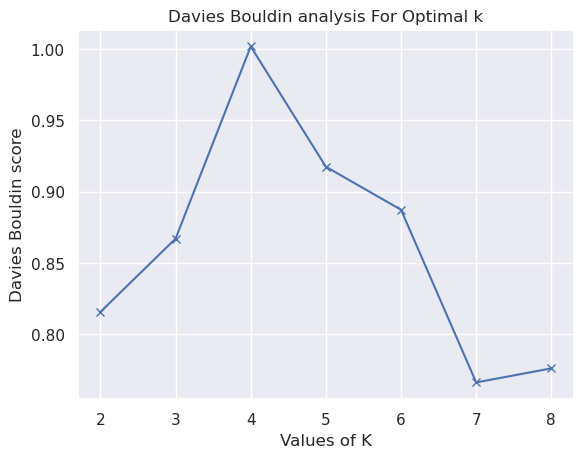

In [21]:
range_n_clusters = range(2,9)
davies_bouldin_avg = []
for num_clusters in range_n_clusters:
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(dfnormalized)
    cluster_labels = kmeans.labels_
    # silhouette score
    davies_bouldin_avg.append(davies_bouldin_score(dfnormalized, cluster_labels))

plt.plot(range_n_clusters,davies_bouldin_avg,'x-')
plt.xlabel('Values of K')
plt.ylabel('Davies Bouldin score')
plt.title('Davies Bouldin analysis For Optimal k')
plt.show()

In [22]:
clusters=2 #from above analysis for optimal value of k=2.
kmeans = KMeans(n_clusters=clusters, init='k-means++')
kmeans.fit(dfnormalized)
pred = kmeans.predict(dfnormalized)
dfnormalized = pd.DataFrame(dfnormalized, columns = ['pca_feature_1','pca_feature_2','pca_feature_3']) # features selected by using PCA
dfnormalized['cluster'] = pred

In [23]:
dfnormalized

,pca_feature_1,pca_feature_2,pca_feature_3,cluster
0,0.049456,-0.003087,-0.051023,0
1,0.045127,-0.049812,-0.053672,0
2,-0.040732,0.044504,-0.042608,1
3,-0.048085,-0.034740,-0.047087,1
4,-0.043313,0.012923,-0.043633,1
...,...,...,...,...
195,-0.041519,-0.034867,0.063985,1
196,-0.034785,0.029879,0.073678,1
197,0.052949,-0.040707,0.065445,0
198,0.059567,0.022761,0.080744,0


In [24]:
df['cluster'] = pred
#df = df.sort_values(by = 'cluster', ignore_index=True)
df

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,0,19,15,39,0
1,0,21,15,81,0
2,1,20,16,6,1
3,1,23,16,77,1
4,1,31,17,40,1
...,...,...,...,...,...
195,1,35,120,79,1
196,1,45,126,28,1
197,0,32,126,74,0
198,0,32,137,18,0


In [25]:
df['cluster'].replace([0,1],
                        ['clust_0','clust 1'], inplace=True)
df['Gender'].replace([0, 1],
                        ['Male', 'Female'], inplace=True)
df

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,Male,19,15,39,clust_0
1,Male,21,15,81,clust_0
2,Female,20,16,6,clust 1
3,Female,23,16,77,clust 1
4,Female,31,17,40,clust 1
...,...,...,...,...,...
195,Female,35,120,79,clust 1
196,Female,45,126,28,clust 1
197,Male,32,126,74,clust_0
198,Male,32,137,18,clust_0


In [26]:
df.iplot(kind="scatter3d",
              x="Annual Income (k$)", y="Age", z="Spending Score (1-100)",
              size=5,colors=["dodgerblue", "lime"],categories="cluster",
              xTitle="Ann Inc", yTitle="Age", zTitle="Spend Sc",
              title="3D view scatter breakout by cluster")